In [2]:
from netCDF4 import Dataset
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import datetime

1. Where is the tip of the trough?
    - Lattitude / Longitude
## Look at Level 6

Upper air Trough over central US leading to SW to NE component 

In [162]:
%run netCDF_Processing.py

In [163]:
cdf = CDFData(hgt_path = "E:\hgt.2012.nc",
              uwind_path = r"E:\uwnd.2012.nc",
              vwind_path = r"E:\vwnd.2012.nc")

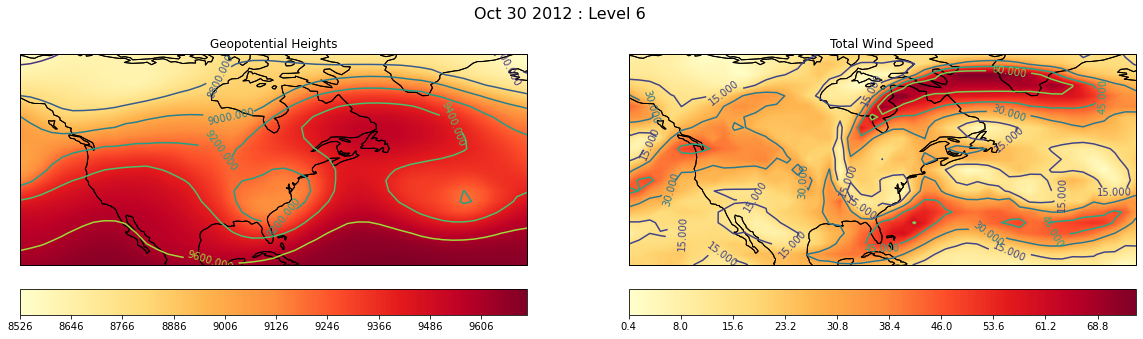

In [164]:
cdf.plot('all',(10,30),6)

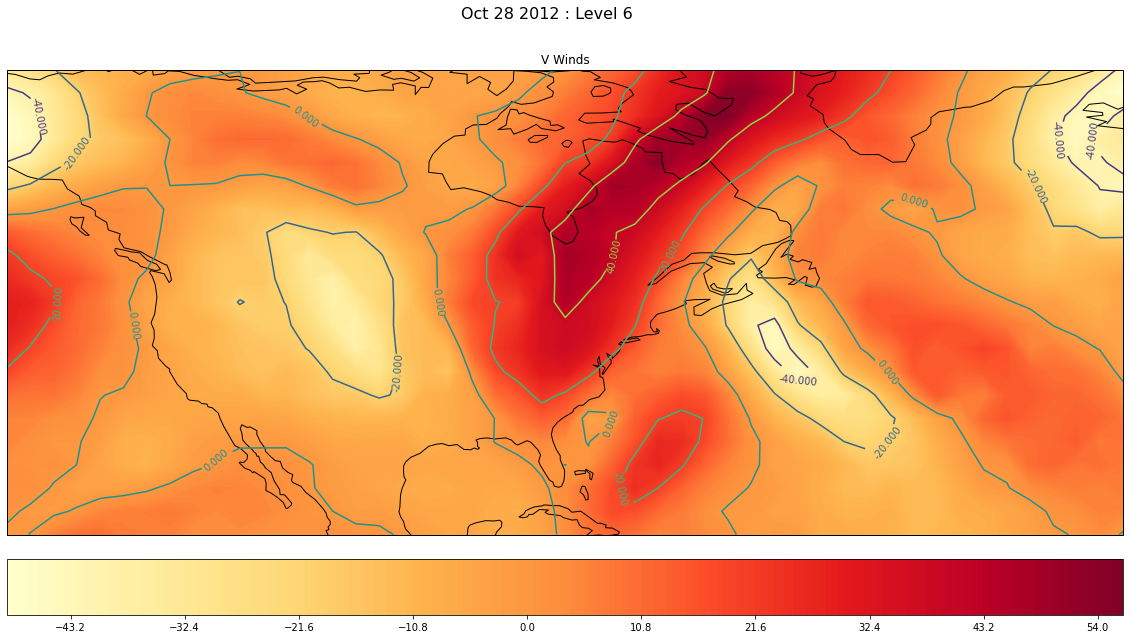

In [165]:
cdf.plot('vwnd',(10,28),6)